In [1]:
import cv2
import torch
import pandas as pd
import numpy as np
import time
from sklearn.utils import shuffle
from scipy.ndimage import gaussian_filter1d
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.set_default_tensor_type('torch.FloatTensor')
data_path = "./data/"
train_file = "{}train/train.mp4".format(data_path)
test_file = "{}test/test.mp4".format(data_path)
labels = [float(speed) for speed in open("{}train/train.txt".format(data_path))]
len(labels)

20400

In [2]:
def ChangeBrightness(image):
    # add some noise to make model robust
    bright_factor = 0.2 + np.random.uniform()
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [3]:
# creates a bunch of frames out of a video
def CreateFrames(fname, outdir):
    cap = cv2.VideoCapture(fname)
    success, img = cap.read()
    currentFrame = 0
    while success:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # crop image to remove dash and make 256 x 256
        img = crop(img)
        cv2.imwrite("%s%d.jpg" % (outdir, currentFrame), img)
        success, img = cap.read()
        currentFrame += 1
    cap.release()
    
#CreateFrames(train_file, "data/train/")
#CreateFrames(test_file, "data/test/")

In [4]:
# crop out dash and sky
def crop(img): return img[114:370, 192:-192]

In [5]:
def CreateTrainData(fnames, speeds):
    d = {"image_path":fnames, "speed":speeds}
    df = pd.DataFrame(data=d)
    return df
    
train_fnames = ["%strain/%d.jpg" % (data_path, i) for i in range(len(labels))]
train_df = CreateTrainData(train_fnames, labels)

In [6]:
def batch_shuffle(df):
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    for i in range(len(df) - 1):
        idx1 = np.random.randint(len(df) - 1)
        idx2 = idx1 + 1
        
        row1 = df.iloc[[idx1]].reset_index()
        row2 = df.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if randInt < 2:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        else:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data
#train_data, val_data = batch_shuffle(train_df)

In [7]:
def GetOpticalFlow(img1, img2):
    gray1, gray2 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    hsv = np.zeros_like(img1)
    hsv[...,1] = 255
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    return bgr

In [8]:
def preprocess_image(image, train=False):
    image = cv2.resize(image, (220, 66), interpolation = cv2.INTER_AREA)
    if train:
        image = ChangeBrightness(image)
    return image


In [9]:
# assumes training data is shuffled
def generate_data(data, batch_size = 32, train=True):
    image_batch = np.zeros((batch_size, 3, 66, 220))
    label_batch = np.zeros((batch_size))
    data_len = len(data.index)
    cur = 0
    while cur * batch_size < data_len:
        start_idx = cur * batch_size
        
        # validation data isn't shuffled and we can iterate frame by frame
        step = 2 if train else 1
        for i, j in enumerate(range(start_idx, min(start_idx + batch_size, data_len-2), step)):
            row1 = data.iloc[j]
            row2 = data.iloc[j + 1]
            
            # get flow data
            img1 = preprocess_image(cv2.imread(row1['image_path']), train)
            img2 = preprocess_image(cv2.imread(row2['image_path']), train)
            flow = GetOpticalFlow(img1, img2)
            f = flow
            flow = np.transpose(flow, (2, 0, 1))
            
            # add gaussian noise
            speed = np.mean([row1['speed'], row2['speed']])
            
            # add noise when the car is moving
            if train and not speed:
                speed += np.random.normal()
            
            image_batch[i] = flow
            label_batch[i] = speed
            
        cur += 1
        if train: image_batch, label_batch = shuffle(image_batch, label_batch)
        x, y = torch.from_numpy(image_batch).type(torch.cuda.FloatTensor), torch.from_numpy(label_batch).type(torch.cuda.FloatTensor)
        yield x, f, y
        

In [10]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class FlowModel(nn.Module):
    
    def __init__(self):
        super(FlowModel, self).__init__()
        
        self.model = nn.Sequential(
        nn.Conv2d(3, 24, 5, 2),
        nn.ELU(),
        nn.Conv2d(24, 36, 5, 2),
        nn.ELU(),
        nn.Conv2d(36, 48, 5, 2),
        nn.ELU(),
        nn.Dropout(0.5),
        nn.Conv2d(48, 64, 3),
        nn.ELU(),
        nn.Conv2d(64, 64, 3),
        nn.ELU(),
        Flatten(),
        nn.Linear(1280, 100),
        nn.ELU(),
        nn.Linear(100, 50),
        nn.ELU(),
        nn.Linear(50, 10),
        nn.ELU(),
        nn.Linear(10, 1))
        
        # initialize weights
        self.model.apply(self.init_weights)
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
            
    def forward(self, x):
        # normalize values
        x = x / 127.5 - 1
        x = self.model(x)
        return x

In [11]:
def train_epoch(model, dl, opt):
    criterion = nn.MSELoss()
    total_loss = 0
    n_batches = 0
    for batch_img, _, batch_label in dl:
        batch_img.cuda()
        model.zero_grad()
        batch_preds = model(batch_img)
        loss = criterion(batch_preds.squeeze(), batch_label)
        loss.backward()
        opt.step()
        total_loss += loss.item()
        n_batches += 1
        
    return total_loss / n_batches

In [12]:
def calculate_validation_loss(model, val_dl):
    n_batches = 0
    total_loss = 0
    criterion = nn.MSELoss()
    for batch_img, _, batch_label in val_dl:
        batch_img.cuda()
        batch_preds = model(batch_img)
        loss = criterion(batch_preds.squeeze(), batch_label)
        total_loss += loss.item()
        n_batches += 1
    return total_loss / n_batches

In [ ]:
# find fastest batch size
#for i in range(10):
#    t0 = time.time()
#    bs = 2**i
#    dl = generate_training_data(train_data, batch_size=bs)
#    train_epoch(model, dl, opt)
#    t1 = time.time()
#    diff = t1 - t0
#    print('Batch size: {}, training time: {}'.format(bs, diff))


In [14]:
bs = 128
model_path = '{}flow_model'.format(data_path)
opt_path = '{}flow_opt'.format(data_path)
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = FlowModel().to(dev)
model.load_state_dict(torch.load(model_path))
opt = torch.optim.Adam(model.parameters())

In [15]:
for i in range(0):
    dl = generate_data(train_data, batch_size=bs)
    val_dl = generate_data(val_data, batch_size=bs, train=False)
    model.train()
    torch.set_grad_enabled(True)
    train_loss = train_epoch(model, dl, opt) / bs
    
    # evaluation mode
    model.eval()
    torch.set_grad_enabled(False)
    val_loss = calculate_validation_loss(model, val_dl) / bs
    print('train_loss: {}, val_loss: {}'.format(train_loss, val_loss))

In [16]:
# save model
torch.save(model.state_dict(), model_path)
torch.save(opt.state_dict(), opt_path)
model = FlowModel().cuda()
model.load_state_dict(torch.load(model_path))
opt.load_state_dict(torch.load(opt_path))

In [ ]:
def EvaluateVideo(fname, model, bs=32, smoothing=10):
    model.eval()
    torch.set_grad_enabled(False)
    
    preds = []
    batch = torch.zeros((bs, 3, 66, 220)).cuda()
    
    # get first frame
    cap = cv2.VideoCapture(fname)
    success, img1 = cap.read()
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img1 = crop(img1)
    img1 = preprocess_image(img1)
    currentFrame = 0
    
    while success:
        
        # evaluate batch
        if currentFrame % bs == 0 and currentFrame != 0:
            batch_preds = model(batch)
            preds += batch_preds.tolist()
            batch = torch.zeros((bs, 3, 66, 220)).cuda()
        
        # second frame
        success, img2 = cap.read()
        if not success:
            break
            
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        img2 = crop(img2)
        img2 = preprocess_image(img2)
        
        # make flow play nice with the model
        flow = GetOpticalFlow(img1, img2)
        flow = np.transpose(flow, (2, 0, 1))
        flow = torch.from_numpy(flow)
        
        batch[currentFrame % bs] = flow
        img1 = img2
        currentFrame += 1
       
    cap.release()
    
    # handle sub batch size leftovers
    end = currentFrame % bs
    if end != 0:
        batch = batch[:end]
        batch_preds = model(batch)
        preds += batch_preds.tolist()
    
    # smooth results
    smooth_preds = gaussian_filter1d(preds, smoothing)
    return preds, smooth_preds

In [23]:
p, sp = EvaluateVideo(test_file, model, smoothing=2)
train_p, train_sp = EvaluateVideo(train_file, model, smoothing=2)

./data/test/test.mp4
True
./data/train/train.mp4
True


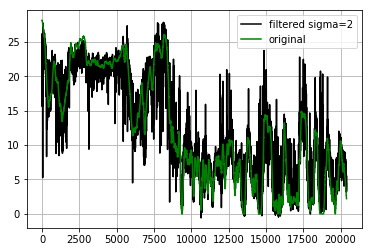

In [25]:
# see how we do on the original data
plt.plot(train_sp, 'k', label='filtered sigma=2')
plt.plot(labels, '-g', label='original')
plt.legend()
plt.grid()
plt.show()

In [21]:
sp = sp.flatten()
sp.size

10797

In [22]:
with open('test.txt', 'w') as f:
    for i in range(sp.size):
        f.write('{}\n'.format(sp[i]))
    last = str(sp[-1] + (sp[-1] - sp[-2]))
    f.write(last)
    f.close()

In [ ]:
# Tada, that's how you get car speed from a dashcam video